In [1]:
%matplotlib notebook
import numpy as np
import re
import pandas as pd
import orbipy as op
import matplotlib.pyplot as plt
import pickle

In [2]:
model = op.crtbp3_model()
precise_model = op.crtbp3_model()
precise_model.integrator.set_params(max_step=np.pi/180)
stm_model = op.crtbp3_model(stm=True)
plotter = op.plotter.from_model(model, length_units='km', velocity_units='m/s')
scaler = plotter.scaler

In [3]:
with open('/home/alex/Desktop/pxdata.txt','r') as fp:
    data = fp.read()

In [4]:
class Polynomial:
    def __init__(self, data):
        self.pol = self.get_polynomial_data(data)
        
    def get_polynomial_data(self, data):
        pol = []
        for row in data.split('\n'):
            powers, coef = re.sub('[{},]','',row.replace('},', ';')).split(';')
            powers = list(map(lambda x: int(x), powers.split(' ')))
            coef = float(coef)
            pol.append([powers, coef])
        return pol
    
    def monomial_eval(self, monomial, states):
        powers = monomial[0]
        coef = monomial[1]
        return coef * np.power(states, powers).prod(axis=1)
    
    def eval(self, states):
        return np.array([self.monomial_eval(monomial, states) for monomial in self.pol]).sum(axis=0)

In [5]:
class SymplecticTransform:
    def __init__(self, model):
        self.mu = model.mu
        self.gamma = 1.-model.mu-model.L1
        self.symp_matrix = self.calc_symp_matrix()
        
    def c(self, n):
        return (self.mu + ((-1)**n)*(((1-self.mu)*self.gamma**(n+1))/((1-self.gamma)**(n+1))))/self.gamma**3
    
    def calc_symp_matrix(self):
        c2 = self.c(2)
        w1 = np.sqrt(-0.5*(c2-2-np.sqrt(9*c2**2-8*c2)))
        l1 = np.sqrt(0.5*(c2-2+np.sqrt(9*c2**2-8*c2)))
        w2 = np.sqrt(c2)
        s1 = np.sqrt(2*l1*((4+3*c2)*l1**2+4+5*c2-6*c2**2))
        s2 = np.sqrt(w1*((4+3*c2)*w1**2-4-5*c2+6*c2**2))
        R = np.array([[2*l1/s1,0,0,-2*l1/s1, 2*w1/s2,0],
                      [(l1**2-2*c2-1)/s1,(-1.*w1**2-2*c2-1)/s2,0,(l1**2-2*c2-1)/s1,0,0],
                      [0,0,1./np.sqrt(w2),0,0,0],
                      [(l1**2+2*c2+1)/s1,(-1.*w1**2+2*c2+1)/s2,0,(l1**2+2*c2+1)/s1,0,0],
                      [(l1**3+(1-2*c2)*l1)/s1,0,0,(-1.*l1**3-(1-2*c2)*l1)/s1,(-1.*w1**3+(1-2*c2)*w1)/s2,0],
                      [0,0,0,0,0,np.sqrt(w2)]])
        return R
    
    def apply(self, states):
        return states @ self.symp_matrix.T

In [6]:
j = np.array([[0,0,0,1,0,0],
              [0,0,0,0,1,0],
              [0,0,0,0,0,1],
              [-1,0,0,0,0,0],
              [0,-1,0,0,0,0],
              [0,0,-1,0,0,0]])

In [7]:
class CanonicTransform:
    def __init__(self, data, model):
        self.mu = model.mu
        self.gamma = 1.-model.mu-model.L1
        self.poly = Polynomial(data)
        self.symplectic_transform = SymplecticTransform(model)
        
    def apply_shift_scale(self, states):
        shift = (self.gamma+self.mu-1)/self.gamma
        states_new = states/self.gamma
        states_new[:,3] -= states[:,1]/self.gamma
        states_new[:,4] += states[:,0]/self.gamma
        states_new[:,0] += shift
        states_new[:,4] += shift
        return states_new
    
    def apply(self, states):
        after_shift = self.apply_shift_scale(states)
        after_symp = self.symplectic_transform.apply(after_shift)
        result = self.poly.eval(after_symp)
        return result

In [8]:
def manifolds(s0, dv, events, num=200):
    traj_upper = []
    traj_lower = []
#     shift = 0
    v_upper = np.linspace(s0[4], s0[4] + dv, num)[1:]
    v_lower = np.linspace(s0[4] - dv, s0[4], num)[:-1]
    det = op.event_detector(model, events)
    for v in v_upper:
        s1 = s0.copy()
        s1[4] = v
        orb, _ = det.prop(s1, 0.0, 1000, last_state='last')
        traj_upper.append(orb)
    for v in v_lower:
        s1 = s0.copy()
        s1[4] = v
        orb, _ = det.prop(s1, 0.0, 1000, last_state='last')
        traj_lower.append(orb)
    
    return traj_lower, traj_upper

In [23]:
def simple_manifolds(s0, dv, max_t=10*np.pi, num=200):
    traj_upper = []
    traj_lower = []
#     shift = 0
    v_upper = np.linspace(s0[4], s0[4] + dv, num)[1:]
    v_lower = np.linspace(s0[4] - dv, s0[4], num)[:-1]
    #det = op.event_detector(model, events)
    for v in v_upper:
        s1 = s0.copy()
        s1[4] = v
        orb = model.prop(s1, 0.0, max_t)
        traj_upper.append(orb)
    for v in v_lower:
        s1 = s0.copy()
        s1[4] = v
        orb = model.prop(s1, 0.0, max_t)
        traj_lower.append(orb)
    
    return traj_lower, traj_upper

In [9]:
with open('../../large_orbs_examples.bin', 'rb') as fp:
    orbs = pickle.load(fp)

In [13]:
def interactive_map(data, buffer):
    def onclick(event):
        if event.button == 3:
            ix, iy = event.xdata, event.ydata
            buffer.append([ix, iy])
            ax.plot(ix, iy, 'or')
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(data['x0'], data['z0'], 'ob')
    ax.plot(model.L1,0,'rx')
#     ax.plot(s0[0],s0[2],'xr')
    ax.axis('equal')
    cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [14]:
with open('../amp.pkl', 'rb') as fp:
    applicability = pickle.load(fp)

<IPython.core.display.Javascript object>


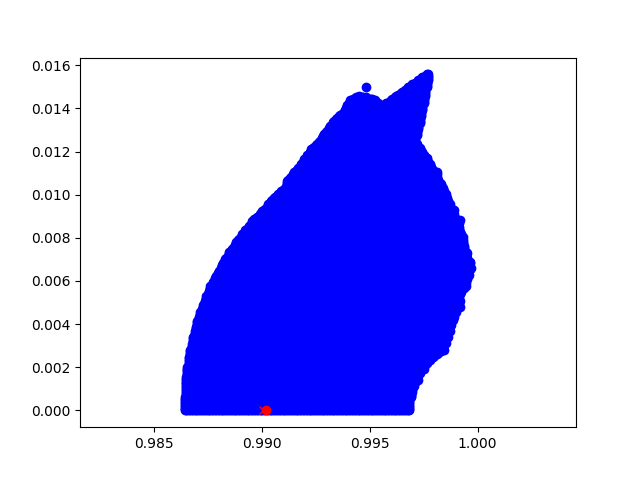

In [15]:
buffer = []
interactive_map(applicability, buffer)

In [16]:
x0 = buffer[-1][0]
z0 = buffer[-1][1]
s0 = model.get_zero_state()
s0[0] = x0
s0[2] = z0

In [17]:
EL1_dist = 1.-model.mu - model.L1
left = op.eventXleft = op.eventX(model.L1-EL1_dist)
right = op.eventX(1.-model.mu)

In [18]:
corr = op.border_correction(model, op.y_direction(), left, right)

In [19]:
sk = op.simple_station_keeping(precise_model,corr, corr)

In [18]:
orb = orbs[-5]

In [21]:
#orb = sk.prop(0.0, s0, 30)

Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 


## Исходня исследуемая орбита

<IPython.core.display.Javascript object>


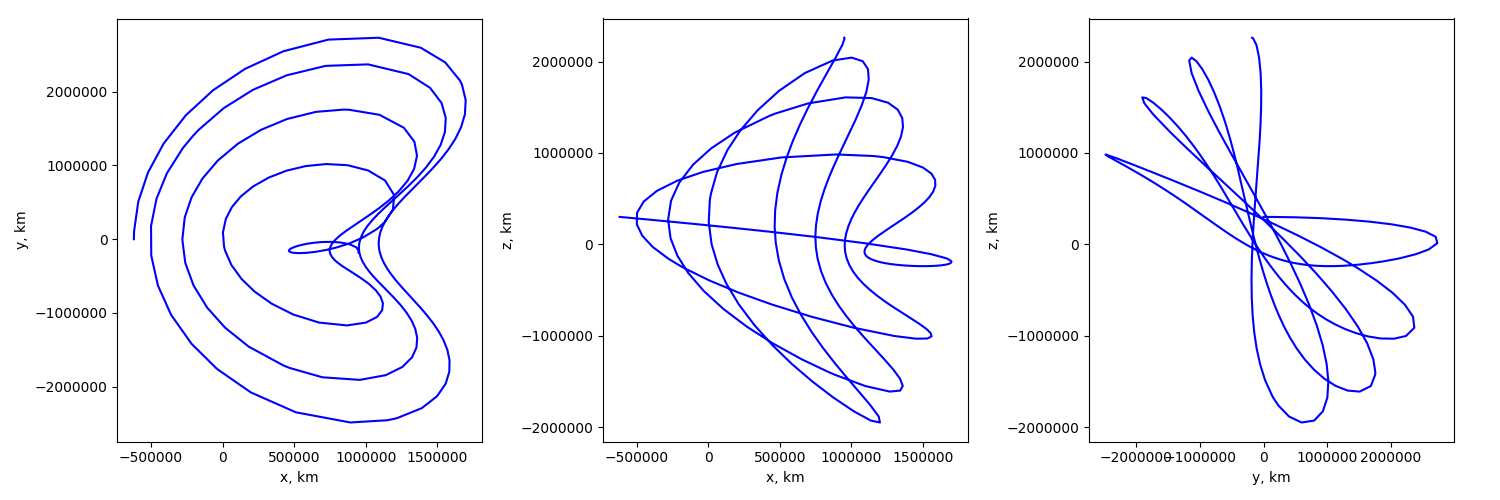

In [12]:
ax = plotter.plot_proj(orb, centers={'x': model.L1, 'y': 0.0, 'z': 0.0})
#plotter.plot_proj(ax=ax, plottables = [plotter.m], marker = 'o')

In [48]:
EL1_dist = 1.-model.mu - model.L1
ileft = op.eventXleft = op.eventX(model.L1-EL1_dist)
#iright = op.eventX(1.-model.mu)
iright = op.eventX(orb['x'].max() + scaler(500000,'km-nd'))
events = [ileft, iright]

In [49]:
trl, tru = manifolds(orb.iloc[0].values[1:], 1e-8, events, 200)

## Траектории в плоскости XY, полученные возмущениями начальных условий, соответствующих исходной орбите 
### Красные - начальная скорость больше (чем скорость соответсвующая орбите вокург L1)
### Синие - начальная скорость меньше

<IPython.core.display.Javascript object>


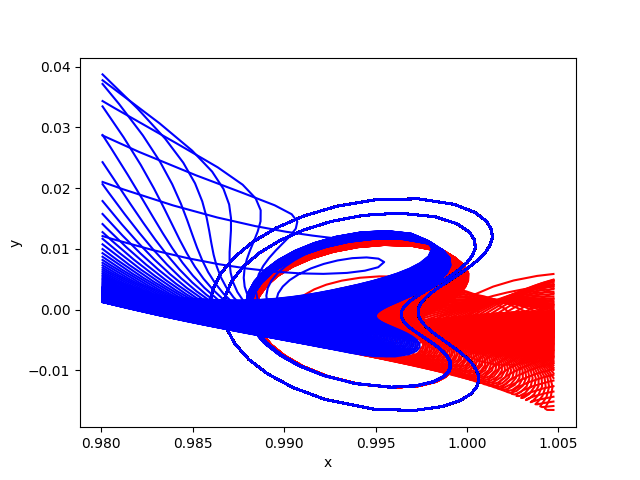

In [50]:
#plt.figure(figsize=(10,8))
plt.xlabel('x')
plt.ylabel('y')
for orb_dist in tru:
    plt.plot(orb_dist['x'], orb_dist['y'], 'r')
for orb_dist in trl:
    plt.plot(orb_dist['x'], orb_dist['y'], 'b')

## Эти же траектории в плоскости TX
### Видно, что неуйсточивое положительное и неустойчивое отрицательное многообразия легко разделимы - плоскости сработают

<IPython.core.display.Javascript object>


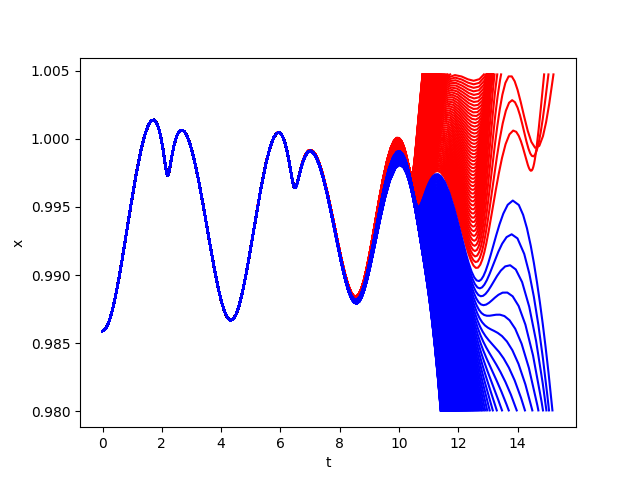

In [52]:
#plt.figure(figsize=(10,8))
plt.xlabel('t')
plt.ylabel('x')
for orb_dist in tru:
    plt.plot(orb_dist['t'], orb_dist['x'], 'r')
for orb_dist in trl:
    plt.plot(orb_dist['t'], orb_dist['x'], 'b')

In [53]:
ct = CanonicTransform(data, model)

In [54]:
ct_upper = [ct.apply(orb_dist.drop('t',axis=1).to_numpy()) for orb_dist in tru]
ct_lower = [ct.apply(orb_dist.drop('t',axis=1).to_numpy()) for orb_dist in trl]

In [31]:
orb_states = orb.drop('t', axis=1).to_numpy()

## Эти же траектории в плоскости TP1 (после преобразования)

<IPython.core.display.Javascript object>


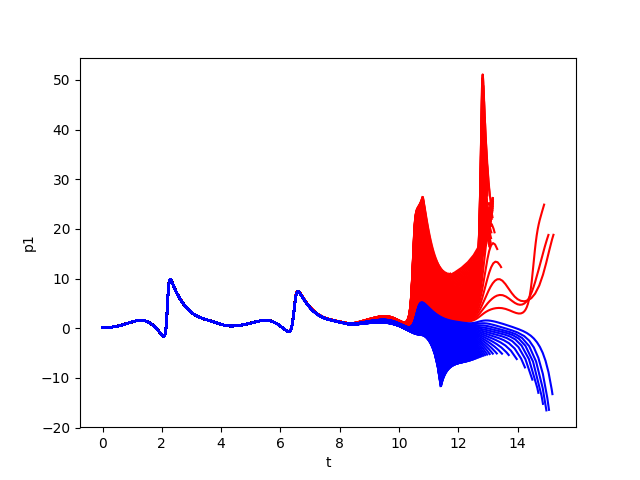

In [55]:
#plt.figure(figsize=(10,8))
plt.xlabel('t')
plt.ylabel('p1')
for orb_dist, tr in zip(tru, ct_upper):
    plt.plot(orb_dist['t'], tr, 'r')
for orb_dist, tr in zip(trl, ct_lower):
    plt.plot(orb_dist['t'], tr, 'b')